In [1]:
import copy
import sys
import time
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
from torch.optim import Adam
# import seaborn as sns

from torch.optim import Adagrad, RMSprop, SGD
from torch.optim.lr_scheduler import ExponentialLR

from gglm.glm.holi import MMDGLM
from gglm.glm.torchglm import TorchGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues
from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

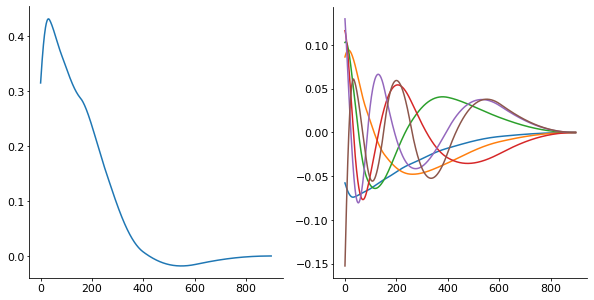

In [2]:
from scipy.io import loadmat
basis = loadmat('./basis.mat')['a']

t_ker = np.arange(0, basis.shape[0], 1)
eta = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=[-5, 1, -0.75, 0.5, -0.2,  0.1])
eta_vals = eta.interpolate(np.arange(0, 898, 1))
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(eta_vals)
ax2.plot(basis)

(array([26., 35., 43., 36., 25., 16., 15.,  8.,  6.,  7.,  7.,  1.,  0.,
         2.,  0.,  1.,  0.,  2.,  0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <a list of 19 Patch objects>)

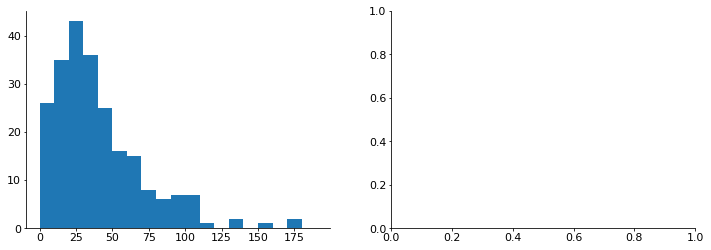

In [3]:
path = "/home/diego/python/generative-glm/cool_stuff/h5test.h5"
f = h5py.File(path, "r")

arg_spikes = (np.array(f['MC']['spikeTimes'], dtype=int)[:, 0], np.array(f['MC']['spikeIndices'], dtype=int)[:, 0] - 1)

dt = 1
t = np.arange(0, 1000, dt)
mask_spikes = np.zeros((len(t), 10), dtype=bool)
mask_spikes[arg_spikes] = True

n_train = 10
mask_spikes_train = mask_spikes[:, :n_train]
n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocov_train = np.mean(auto_covariance(mask_spikes_train, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
# mask_spikes_val = mask_spikes[:, n_train:]
# fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)

st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)
bins = np.arange(0, 200, 10)
fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2)
ax1.hist(isi_train, bins=bins)

# st_val = SpikeTrain(t, mask_spikes_val)
# isi_val = st_val.isi_distribution()
# mean_isi_val = np.mean(isi_val)

In [4]:
def fun_metrics_ml(model, t, mask_spikes, X):
    n_batch_fr = 25
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    u_fr, r_fr, mask_spikes_fr = model.sample(st_train.t, shape=(n_batch_fr,))
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    return dict(mu_fr=mu_fr)

### ML

In [5]:
coefs = np.zeros(basis.shape[1])
eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=coefs)

lr = 1e-1
num_epochs = 200
n_metrics = 10

glm = TorchGLM(u0=-5, eta=eta0.copy(), noise='bernoulli')
# glm.metrics = fun_metrics_ml
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=fun_metrics_ml, n_metrics=n_metrics)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_train_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk_train

_, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask)
r_train_dc_ml = np.mean(r_train_dc_ml, 1) * 1000
# _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(st_train.mask.shape[1],))
# _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(200,))
# r_fr_ml = r_fr_ml * 1000
# st_fr_ml = SpikeTrain(st_train.t, mask_spikes_fr_ml)
# isi_fr_ml = st_fr_ml.isi_distribution()
# mean_isi_fr_ml = np.mean(isi_fr_ml)
# mean_r_fr_ml = np.mean(r_fr_ml, 1)
# sum_r_fr_ml = np.sum(r_fr_ml, 1)

t_long = np.arange(0, 7000, 1)
_, r_fr_ml_long, mask_spikes_fr_ml_long = glm.sample(t_long, shape=(st_train.mask.shape[1],))
st_fr_ml_long = SpikeTrain(t_long, mask_spikes_fr_ml_long)
isi_fr_ml = st_fr_ml_long.isi_distribution()
mean_isi_fr_ml = np.mean(isi_fr_ml)
r_fr_ml_long = r_fr_ml_long * 1000
autocov_ml_long = np.mean(auto_covariance(mask_spikes_fr_ml_long, method='fft', subtract_mean=False, stationary_signal=False, biased=False), 1)

 epoch 199 of 200 nll 1112.0382

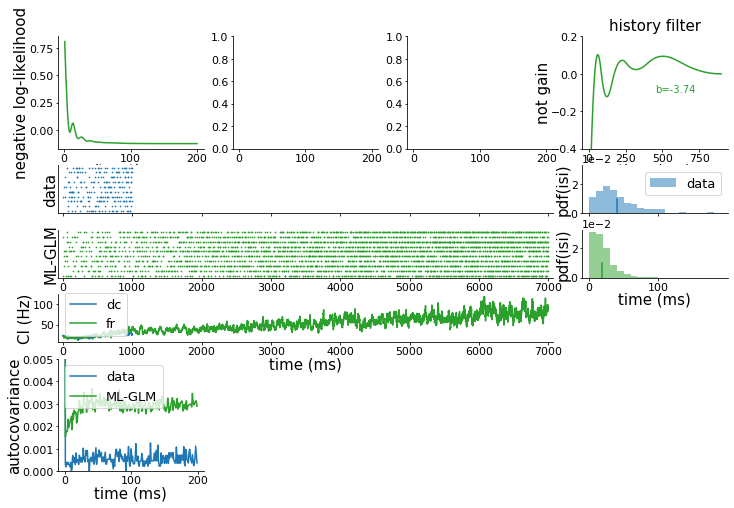

In [6]:
for key, val in metrics_ml.items():
    metrics_ml[key] = np.array(val)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig = plt.figure(figsize=(12, 8))
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)

ax00.plot(iterations_ml, nll_normed_train_ml, color=palette['ml'])
# ax1.plot(iterations_ml, metrics_ml['nll_val'], color=palette['ml'])
myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')

# ax2.plot(iterations_ml[::n_metrics], metrics_ml['mu_fr'], '-.', color=palette['ml'])
# ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
# # ax2.set_ylim(0, 25)
# myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
# ax2.legend()

glm.eta.plot(t=t_ker, ax=ax03, exp_values=False, color=palette['ml'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.set_ylim(-0.4, 0.2)

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_ml.plot(ax=ax5, ms=0.7, color=palette['ml'])
st_fr_ml_long.plot(ax=ax20, ms=0.7, color=palette['ml'])
ax20.set_yticks([])
ax20.set_ylabel('ML-GLM')

ax30.plot(t, r_train_dc_ml, color=palette['d'], label='dc')
ax30.plot(t_long, np.mean(r_fr_ml_long, 1), color=palette['ml'], label='fr')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

ax21.hist(isi_fr_ml, density=True, alpha=0.5, color=palette['ml'], label='ML-GLM', bins=bins)
ax21.plot([mean_isi_fr_ml, mean_isi_fr_ml], [0, y1], '-', color=palette['ml'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

argf = 200
ax40.plot(autocov_train[:argf], color=palette['d'], label='data')
ax40.plot(autocov_ml_long[:argf], color=palette['ml'], label='ML-GLM')
ax40.set_ylim(0, 5e-3)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='autocovariance')
ax40.legend()

fig.subplots_adjust(hspace=0.35)

fig.savefig('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/ML.pdf', transparent=True)

### MMD

In [8]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    dt = 1
    T_train = t[-1] - t[0] + t[1]
    mu_fr = np.mean(np.sum(mask_spikes_fr.double().numpy(), 0)) / T_train * 1000
    return dict(mu_fr=mu_fr)

In [9]:
def phi_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T

def ker_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    return fr1[:, None] * fr2[None, :]

dic_ker_strings = {'phi_fr': "fr*fr'", 'ker_fr': "fr*fr'"}
dic_ker_name = {'phi_fr': "product", 'ker_fr': 'product', 'phi_sum': "sum_product", 
               'kernel_expr': "gaussian", 'kernel_id': "canonical_dot"}

In [11]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_fr, None, 1e-2, False, 1e-2, 1e0
phi, kernel, lam_mmd, biased, lr, clip = None, ker_fr, 1e1, True, 5e-3, 1e0

sd2 = 1e-2

beta0, beta1 = 0, 0
n_batch_fr = 50
num_epochs = 1200
n_metrics = 10

time0 = time.time()
u00 = glm.u0
eta0 = glm.eta.copy()

# eta0_scaled = glm.eta.copy()
# eta0_scaled.coefs = eta0_scaled.coefs * 0.1
# mmdglm = CIMMDGLM(u0=glm.u0, eta=eta0_scaled.copy())

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=True, 
                                              n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

_, r_fr_mmd_long, mask_spikes_fr_mmd_long = mmdglm.sample(t_long, shape=(st_train.mask.shape[1],))
st_fr_mmd_long = SpikeTrain(t_long, mask_spikes_fr_mmd_long)
isi_fr_mmd_long = st_fr_mmd_long.isi_distribution()
mean_isi_fr_mmd_long = np.mean(isi_fr_mmd_long)
r_fr_mmd_long = r_fr_mmd_long * 1000
autocov_mmd_long = np.mean(auto_covariance(mask_spikes_fr_mmd_long, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)

time1 = time.time()
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')
# phi.__name__, kernel, lam_mmd, num_epochs, lr, clip, beta0, beta1, n_batch_fr, lam_mmd, biased
# optim.__class__.__name__, u00, eta0, mmdglm.u0, mmdglm.eta, 

 epoch 1199 of 1200 loss 33530.64453125
 took 181.3784635066986 seconds 3.0229743917783103 minutes


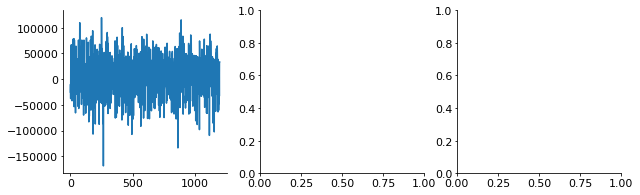

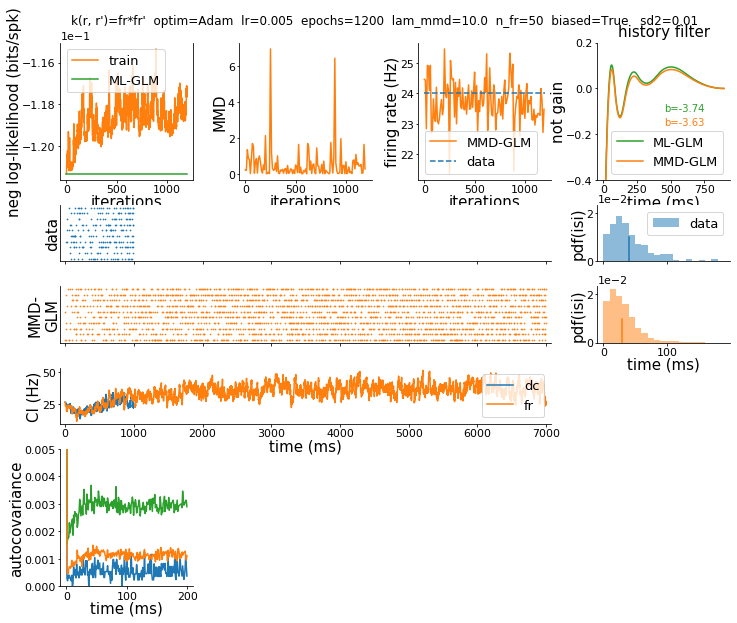

In [17]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
ax1.plot(loss_mmd)
# ax2.plot(nll_train)
# ax3.plot((loss_mmd - nll_train) / lam_mmd)
# ax3.set_ylim(0, 1e4)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig = plt.figure(figsize=(12, 10))
fig.suptitle(title, fontsize=12, y=0.92)
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)

ax00.plot(iterations_mmd, nll_normed_train, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train[0], nll_normed_train[0]], '-', 
          label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax00.legend()
myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
yf = np.median(metrics_mmd['mmd'][-10:] * 2)
# ax01.set_ylim(-1e2, yf)
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
ax02.legend()

glm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
ax03.legend()
ax03.set_ylim(-0.4, 0.2)

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

# ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
ax21.hist(isi_fr_mmd_long, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
ax21.plot([mean_isi_fr_mmd_long, mean_isi_fr_mmd_long], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
st_fr_mmd_long.plot(ax=ax20, ms=0.7, color=palette['mmd'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('MMD-\nGLM')

ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
ax30.plot(t_long, np.mean(r_fr_mmd_long, 1), color=palette['mmd'], label='fr')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

argf = 200
ax40.plot(autocov_train[:argf], color=palette['d'], label='data')
ax40.plot(autocov_ml_long[:argf], color=palette['ml'], label='ML-GLM')
ax40.plot(autocov_mmd_long[:argf], color=palette['mmd'], label='MMD-GLM')
ax40.set_ylim(0, 5e-3)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='autocovariance')
# ax40.legend()

# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(hspace=0.45, wspace=0.35)

fig_name = 'mmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

import os
list_files = os.listdir('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/')

ii = 1
while fig_name + '_' + str(ii) + '.pdf' in list_files:
    ii += 1
fig_name += '_' + str(ii) + '.pdf'

fig.savefig('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/' + fig_name, transparent=True)